In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
from scipy import signal

# Treadmill data analysis
Quentin Decultot, JJ Aucouturier, 2021

In [2]:
# load examples 
file_1 = 'treadmill_1_21_05_06_14_24'
step_data_1 = pd.read_csv('data/'+file_1+'.csv')
sound_data_1 = pd.read_csv('data/'+file_1+'_sound.csv')

file_2 = 'treadmill_2_21_05_06_15_02'
step_data_2 = pd.read_csv('data/'+file_2+'.csv')
sound_data_2 = pd.read_csv('data/'+file_2+'_sound.csv')

c:\users\aucouturier\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (0,1,2,3,4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Debug

Quentin: this section lists potential issues found in the files, which should be fixed in the experimental code. 

### Time reset in file 1

File treadmill_1_21_05_06_14_24 has a pb. Headers ("time, x_left...") are inserted a second time at time = 5000, and time is reset to 0 after this position. 

In [4]:
print(step_data_1[pd.to_numeric(step_data_1.time, errors='coerce').isnull()])

      time  x_left  y_left  z_left  x_right  y_right  z_right
5000  time  x_left  y_left  z_left  x_right  y_right  z_right


In [5]:
step_data_1.loc[4995:5005]

,time,x_left,y_left,z_left,x_right,y_right,z_right
4995,4995.06422996521,0.3898674307220942,-0.591251647693392,-2.009833909870968,-3.0451940738555447,-1.2622521112901666,-0.3461191397861185
4996,4996.06422996521,0.38477409233570015,-0.591251647693392,-2.0072872129705015,-3.0401012309403206,-1.2622521112901666,-0.3461191397861185
4997,4997.06422996521,0.38477409233570015,-0.5887048981723968,-2.0072872129705015,-3.0350083880250964,-1.2622521112901666,-0.3461191397861185
4998,4998.06422996521,0.39241409991529164,-0.5887048981723968,-2.0072872129705015,-3.0401012309403206,-1.2622521112901666,-0.3461191397861185
4999,4999.06422996521,0.4000541074948831,-0.5887048981723968,-2.0047405160700347,-3.0426476523979327,-1.2622521112901666,-0.3461191397861185
5000,time,x_left,y_left,z_left,x_right,y_right,z_right
5001,0.0637972354888916,1.0723747744989174,-0.24234696331709582,0.45536868978057754,-3.1368652463295805,-1.3845040595644278,-0.2951743396600115
5002,1.0637972354888916,0.9756013451574272,-0.2576274604430644,0.4681021742829099,-3.3049290625319796,-1.3539410724958643,-0.3155522597104543
5003,2.0637972354888916,1.0367214057941574,-0.31874944894694135,0.45536868978057754,-3.1903400969394347,-1.272439773646358,-0.3257412197356757
5004,3.0637972354888916,0.9756013451574272,-0.34676369367788507,0.4349951145768465,-3.147050932160029,-1.272439773646358,-0.3155522597104543


This creates pb when plotting data (value 'time' in col time is not a numeric (have to coerce it into a Nan), and also uncertainty as to what time should be considered (start at 5000 ? Add 5000 to all values after 5000 ?)

(-1000.0, 6000.0)

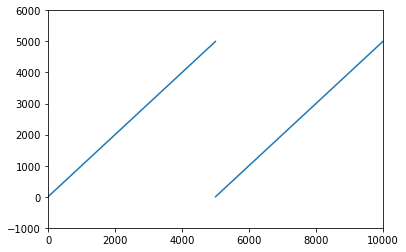

In [6]:
plt.plot(pd.to_numeric(step_data_1.time, errors='coerce'))
plt.xlim([0,10000])
plt.ylim([-1000,6000])

File treadmill_2_21_05_06_15_02 doesn't have the same problem

In [7]:
print(step_data_2[pd.to_numeric(step_data_2.time, errors='coerce').isnull()])

Empty DataFrame
Columns: [time, x_left, y_left, z_left, x_right, y_right, z_right]
Index: []


For now, simply delete data before 5000 in first file. 

In [3]:
step_data_1 = step_data_1.loc[5001:].reset_index()

In [9]:
print(step_data_1[pd.to_numeric(step_data_1.time, errors='coerce').isnull()])

Empty DataFrame
Columns: [index, time, x_left, y_left, z_left, x_right, y_right, z_right]
Index: []


## Step data analysis

The goal of this section is to segment step data corresponding to each trial/note, and to extract features from each step, resulting in a dataframe in the form of: 
<table>
<thead>
  <tr>
    <th>subj</th>
    <th>trial_id</th>
    <th>note</th>
    <th>step_feature</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>1</td>
    <td>1</td>
    <td>A4</td>
    <td>2.3</td>
  </tr>
  <tr>
    <td>1</td>
    <td>2</td>
    <td>Bb3</td>
    <td>0.6</td>
  </tr>
  <tr>
    <td>1</td>
    <td>...</td>
    <td></td>
    <td></td>
  </tr>
  <tr>
    <td>1</td>
    <td>1500</td>
    <td>C#5</td>
    <td>1.8</td>
  </tr>
</tbody>
</table>

In [4]:
step_data_1 = step_data_1.apply(pd.to_numeric)
step_data_2 = step_data_2.apply(pd.to_numeric)


### Observations

#### Irregular step timing

Quentin & JJ do not have the same timing: JJ looks a lot more irregular than Quentin. We can't assume that the sound position gives the position of the step (e.g. can't for-loop in sounds to look in step data). \
<b>Strategy:</b> first find start and end of each step in step data(e.g. on z), then try to assign each step to a sound (e.g. if sound_time is in [step_start, step_stop]), possibly skip sound when there is ambiguity.

JJ:

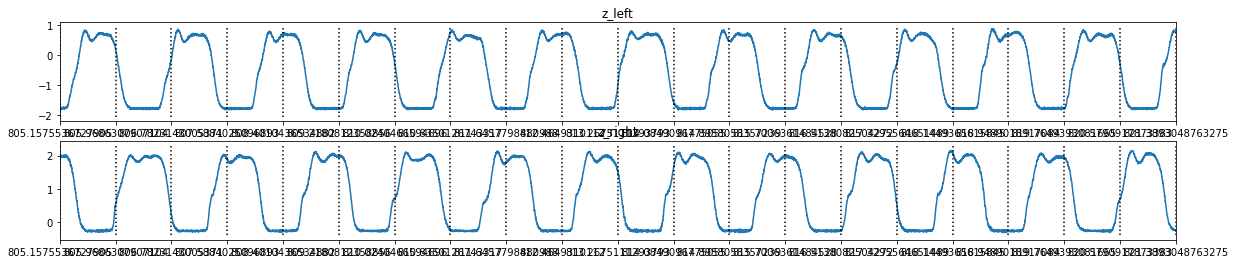

In [11]:
dims= ['z_left','z_right']
fig = plt.figure(figsize=(20,2*len(dims)))
for index, dim in enumerate(dims): 
    ax = fig.add_subplot(len(dims),1,index+1)
    plt.plot(step_data_1['time']/1000,step_data_1[dim])
    plt.title(dim)
    for id,row in sound_data_1.iterrows(): 
        plt.plot([row.time,row.time],[step_data_1[dim].min(),step_data_1[dim].max()],'k:')
    plt.xlim([1000,1020])


Quentin:

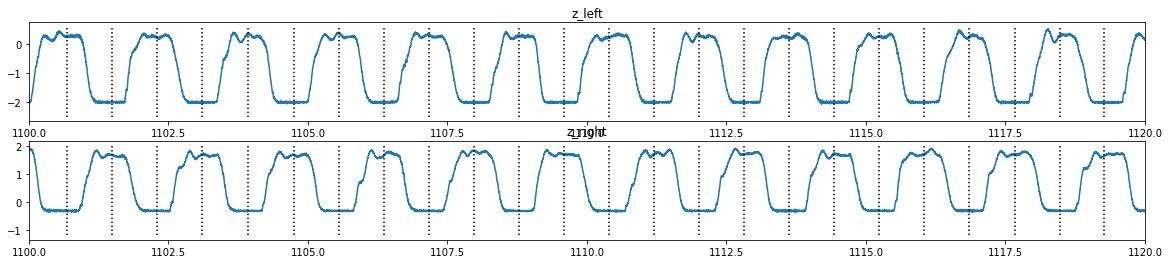

In [12]:
dims= ['z_left','z_right']
fig = plt.figure(figsize=(20,2*len(dims)))
for index, dim in enumerate(dims): 
    ax = fig.add_subplot(len(dims),1,index+1)
    plt.plot(step_data_2['time']/1000,step_data_2[dim])
    plt.title(dim)
    for id,row in sound_data_2.iterrows(): 
        plt.plot([row.time,row.time],[step_data_2[dim].min(),step_data_2[dim].max()],'k:')
    plt.xlim([1100,1120])


#### Step data easier to segment on z

Step data is a lot easier to segment on z_left and z_right than  x,y. \
<b>Strategy:</b> find step start/stop on z, then apply to x,y (because same timing). Note also that Y_right more noisy than Y_left. 

In [ ]:
dims= ['z_left','z_right', 'x_left','x_right', 'y_left','y_right']
fig = plt.figure(figsize=(20,2*len(dims)))
for index, dim in enumerate(dims): 
    ax = fig.add_subplot(len(dims),1,index+1)
    plt.plot(step_data_1['time']/1000,step_data_1[dim])
    #plt.plot(step_data_1['time']/1000,step_data_1[dim])
    
    plt.title(dim)
    for id,row in sound_data_1.iterrows(): 
        plt.plot([row.time,row.time],[step_data_1[dim].min(),step_data_1[dim].max()],'k:')
    plt.xlim([1100,1120])


#### Resampling

Note: estimated sample rate = 1000Hz

In [ ]:
len(step_data_1.time)/(step_data_1.time.max()/1000)

In [6]:
SR = 1000

We wouldn't lose much by downsampling to 100Hz (10ms precision on the onset/duration of the step, possibly), and divide memory/cpu by 10. \
<b> Strategy: </b> For now, downsample in notebook. If this is confirmed, maybe sample at 100Hz during the experiment, and put sr in config file. 

In [ ]:
x = np.array(step_data_1['z_left'])
t = np.array(step_data_1['time'])
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,2,1)
plt.plot(t/1000,x,'k')
plt.xlim([1000, 1001])
plt.title('%dHz'%sr)
ax = fig.add_subplot(1,2,2)
new_sr = 100
(x,t)=signal.resample(x,t=t,num=int((len(x)/sr)*new_sr))
plt.plot(t/1000,x,'b')
plt.xlim([1000, 1001])
plt.title('%dHz'%new_sr)

#### Detrend

Z data has a trend, which makes using a fixed threshold to segment step impossible (min + 5% at the beginning is < min at the end)

In [ ]:
times= step_data_1.time
x = step_data_1.z_left

# adapt threshold to min + a percent of (range of x)
x_min = np.percentile(x,1) 
x_max = np.percentile(x,99)
percent_range = 0.05
threshold = x_min + (x_max-x_min)*percent_range
mask = np.diff(1 * (x > threshold) != 0)

plt.plot(times/1000, x, 'k')
plt.plot(times[:-1][mask]/1000,x[:-1][mask], 'go', markersize=8)
plt.plot([times.min()/1000,times.max()/1000],[threshold,threshold],'b:')
    

That trend is there for both dataset, so it's not a feature of the participant but a bug of the treadmill. \
<b> Strategy: </b> Detrend before analysis

### Preprocessing

#### Resample

Text(0.5, 1.0, '100Hz')

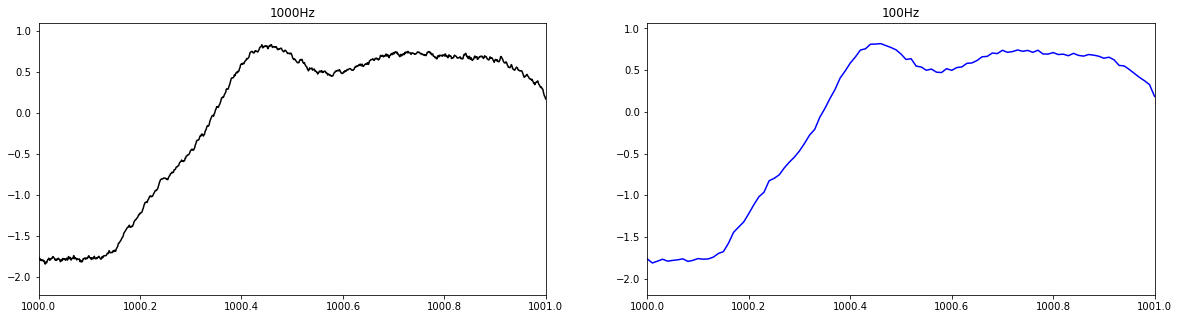

In [10]:
def resample_all_cols(df, sr, new_sr, time_col='time'): 
    # resample all cols except time_col to new_sr
    
    # list data columns (neither index nor time)
    data_cols = list(df)
    if time_col in data_cols:
        data_cols.remove(time_col)
    if 'index' in data_cols:
        data_cols.remove('index')
    
    resampled_df = pd.DataFrame()
    for data_col in data_cols: 
        data = np.array(df[data_col])
        time = np.array(df[time_col])
        (new_data,new_time) = signal.resample(data,
                                t=time,
                                num = int((len(data)/sr)*new_sr))
        resampled_df[data_col] = new_data
    resampled_df['time'] = new_time
    return resampled_df

# test
# resample to 100Hz
rs_step_data_1 = resample_all_cols(step_data_1,SR,100)
# plot original vs resampled 
x = np.array(step_data_1['z_left'])
t = np.array(step_data_1['time'])
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,2,1)
plt.plot(t/1000,x,'k')
plt.xlim([1000, 1001])
plt.title('%dHz'%SR)
ax = fig.add_subplot(1,2,2)
x = np.array(rs_step_data_1['z_left'])
t = np.array(rs_step_data_1['time'])
plt.plot(t/1000,x,'b')
plt.xlim([1000, 1001])
plt.title('%dHz'%100)

#### Detrend

Text(0.5, 1.0, '100Hz')

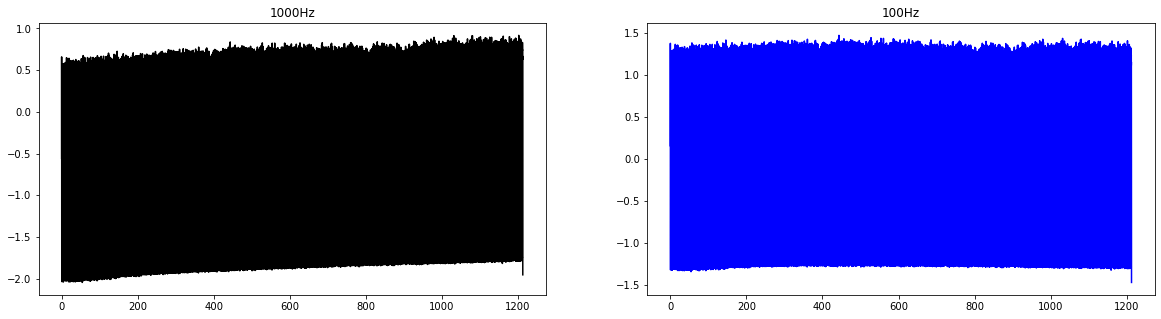

In [12]:
def detrend_all_cols(df,time_col='time'):
    # remove linear trend in data
    
    # list data columns (neither index nor time)
    data_cols = list(df)
    if time_col in data_cols:
        data_cols.remove(time_col)
    if 'index' in data_cols:
        data_cols.remove('index')
        
    detrend_df = pd.DataFrame()
    for data_col in data_cols: 
        detrend_df[data_col]=signal.detrend(np.array(df[data_col]),
                                             type='linear')
    detrend_df['time'] = df[time_col]
    return detrend_df

# test
rs_step_data_1 = resample_all_cols(step_data_1,SR,100)
de_step_data_1 = detrend_all_cols(rs_step_data_1)

x = np.array(rs_step_data_1['z_left'])
t = np.array(rs_step_data_1['time'])
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,2,1)
plt.plot(t/1000,x,'k')
plt.title('%dHz'%SR)
ax = fig.add_subplot(1,2,2)
x = np.array(de_step_data_1['z_left'])
t = np.array(de_step_data_1['time'])
plt.plot(t/1000,x,'b')
plt.title('%dHz'%100)
    

### Segmentation

The goal of this section is to segment step data corresponding to each trial/note, downsample it to a suitable sampling rate, and store it in a dataframe.  
<table>
<thead>
  <tr>
    <th>subj</th>
    <th>trial_id</th>
    <th>note</th>
    <th>step_data_left_x</th>
    <th>step_data_left_y</th>
    <th>...</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>1</td>
    <td>1</td>
    <td>A4</td>
    <td>[2.3,3.5,...,4.8]</td>
    <td>[-3.2,-0.8,...]</td>
    <td>...</td>
  </tr>
</tbody>
</table>

(604.0, 606.0)

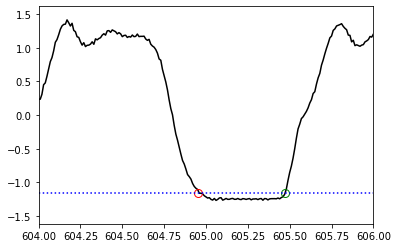

In [62]:
# find start and stop times for each step in time series x
# minduration in sec.
def segment_steps(times,x, min_duration):
    start_times = []
    end_times = []
    
    # adapt threshold to min + a percent of (range of x)
    x_min = np.percentile(x,1) 
    x_max = np.percentile(x,99)
    percent_range = 0.05
    threshold = x_min + (x_max-x_min)*percent_range
    
    # detect up and down crossings     
    mask = np.diff(1*(x > threshold)) # 1 if crosses threshold up, -1 if crosses down
    start_times = times[:-1][mask>0] 
    end_times = times[:-1][mask<0] 
    
    # drop potential endings that occur before first start
    end_times = [end_time for end_time in list(end_times) if end_time > list(start_times)[0]]
    # drop potential starts that occur after the last ending
    start_times = [start_time for start_time in list(start_times) if start_time < list(end_times)[-1]]
        
    # eliminate false alarms (ie. consecutive starts or stops within a short time window, ex. 0.1s)
    start_times, end_times = zip(*[(start_time,end_time) for start_time,end_time in zip(start_times,end_times) if (end_time-start_time) > (min_duration*1000)])
    
    return start_times, end_times, threshold

#test    
rs_step_data_1 = resample_all_cols(step_data_1,SR,100)
de_step_data_1 = detrend_all_cols(rs_step_data_1)

times = de_step_data_1.time
x = de_step_data_1.z_left
start_times, end_times, threshold = segment_steps(times,x, 0.1)
plt.plot(times/1000, x, 'k')
plt.plot(np.array(start_times)/1000,[threshold]*len(start_times), 'go', markersize=8, markerfacecolor='None')
plt.plot(np.array(end_times)/1000,[threshold]*len(end_times), 'ro', markersize=8, markerfacecolor='None')
plt.plot([times.min()/1000,times.max()/1000],[threshold,threshold],'b:')
plt.xlim([604,606])

In [78]:
# create dataframe of steps

# extract step times
rs_step_data_1 = resample_all_cols(step_data_1,SR,100)
de_step_data_1 = detrend_all_cols(rs_step_data_1)
start_times, end_times, threshold = segment_steps(de_step_data_1.time,de_step_data_1.z_left, 0.1)

print("%d starts, %d ends"%(len(start_times),len(end_times)))

step_datas = []
step_sizes=[]
step_foots = []
for start_time,end_time in zip(start_times,end_times): 
    #print("start:%.0f - end:%.0f; "%(start_time,end_time),end='')
    step_data = list(de_step_data_1[(de_step_data_1.time >=start_time)&(de_step_data_1.time <end_time)].z_left)
    step_datas.append(step_data)
    step_foots.append('left')

steps = pd.DataFrame({'start':start_times, 'end': end_times, 'step_data': step_datas, 'foot':step_foots})

746 starts, 746 ends


In [79]:
steps

,start,end,step_data,foot
0,8.400638e+02,1.900064e+03,"[-1.1713502653973575, -1.0451636494903147, -0....",left
1,2.620064e+03,3.740064e+03,"[-1.2340401831270442, -1.1527528775060936, -1....",left
2,4.360064e+03,5.540064e+03,"[-1.2083351453693076, -1.1413393270672163, -1....",left
3,6.090064e+03,7.210064e+03,"[-1.226346209889488, -1.149124510723352, -1.12...",left
4,7.790064e+03,8.900064e+03,"[-1.2027594312679768, -1.1080291744379531, -1....",left
...,...,...,...,...
741,1.204960e+06,1.206010e+06,"[-1.206364761670679, -1.1396303035519875, -1.0...",left
742,1.206560e+06,1.207680e+06,"[-1.1997128787732498, -1.0834626301543084, -0....",left
743,1.208190e+06,1.209290e+06,"[-1.2021430089854608, -1.1483404600514846, -1....",left
744,1.209820e+06,1.210880e+06,"[-1.2176545752446084, -1.078006334353963, -0.9...",left


In [80]:
# to do: 
# collect left and right steps in the same df (index as foot = left or right)
# join trials (notes) on steps where note_time in [start,end] (https://stackoverflow.com/questions/25688524/can-one-use-comparisons-to-merge-two-pandas-data-frames)
# if 2 matches (eg. 1 left and 1 right) for one trial, delete trial

### Step feature extraction

The goal of this section is to extract features from each step data.  
<table>
<thead>
  <tr>
    <th>subj</th>
    <th>trial_id</th>
    <th>note</th>
    <th>step_data_left_x</th>
    <th>max_amplitude_left_x</th>
    <th>duration_left_x</th>
    <th>step_data_left_y</th>
    <th>max_amplitude_left_y</th>
    <th>...</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>1</td>
    <td>1</td>
    <td>A4</td>
    <td>[2.3,3.5,...,4.8]</td>
    <td>6.8</td>
    <td>1.3</td>
    <td>[-3.2,-0.8,...]</td>
    <td>...</td>
  </tr>
</tbody>
</table>

## Reverse-correlation analysis

This takes a dataframe in the form:
<table>
<thead>
  <tr>
    <th>subj</th>
    <th>trial_id</th>
    <th>note</th>
    <th>step_feature</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>1</td>
    <td>1</td>
    <td>A4</td>
    <td>2.3</td>
  </tr>
  <tr>
    <td>1</td>
    <td>2</td>
    <td>Bb3</td>
    <td>0.6</td>
  </tr>
  <tr>
    <td>1</td>
    <td>...</td>
    <td></td>
    <td></td>
  </tr>
  <tr>
    <td>1</td>
    <td>1500</td>
    <td>C#5</td>
    <td>1.8</td>
  </tr>
</tbody>
</table>

## Visualisation

In [6]:
tread_file = "treadmill/data/treadmill__21_04_27_12_09.csv"
sound_file = "treadmill/data/treadmill__21_04_27_12_09_sound.csv"

In [7]:
step=pd.read_csv(tread_file)
sound=pd.read_csv(sound_file)

(110.0, 120.0)

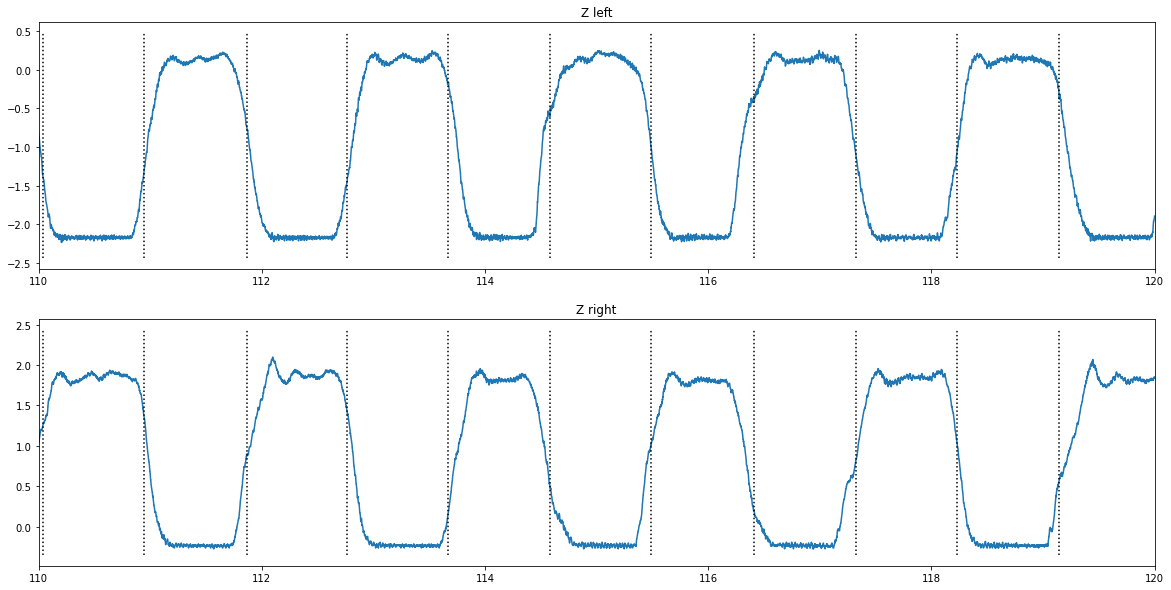

In [14]:
fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(2,1,1)
plt.plot(step['time']/1000,step['z_left'])
plt.title('Z left')
for id,row in sound.iterrows(): 
    plt.plot([row.time,row.time],[step.z_left.min(),step.z_left.max()],'k:')
plt.xlim([110,120])

ax = fig.add_subplot(2,1,2)
plt.plot(step['time']/1000,step['z_right'])
plt.title('Z right')
for id,row in sound.iterrows(): 
    plt.plot([row.time,row.time],[step.z_right.min(),step.z_right.max()],'k:')
plt.xlim([110,120])

